In [1]:
from __future__ import division
from pylab import *             # includes numpy
import matplotlib.pyplot as plt # plotting libraries from matlab
import sys
sys.path.insert (2, '/global/homes/s/salsum/luxsalsum/libNESTgit/libNESTRun04/libNEST')
sys.path.insert(0,'/project/projectdirs/lux/Tools/LUXcode/Trunk/DataAnalysis/Python/' )
sys.path.insert(0,'/project/projectdirs/lux/Tools/LUXcode/Trunk/DataAnalysis/Python/aLib' )
sys.path.insert(2, '//global/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/')
sys.path.insert(2, '/global/project/projectdirs/lux/Tools/anaconda/lib')
sys.path.insert(2, '//global/project/projectdirs/lux/data/')
import scipy 
import scipy.interpolate as ip
import aLib
import scipy.io as sio
import pandas as pd
import libNEST

%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 18})

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> Setup NEST </h1>

In [2]:
Xe_density=2.863
PT=1 #ER Particle Type
En=10 #energy, doesn't matter here

#Construct the NEST object
NEST=libNEST.NEST(PT,En,-1,Xe_density,-1) #PT, Energy, EField - Doesn't matter, density, dT
#Construcrt a detector object and start with LUX
myDet=libNEST.Detector()
myDet.LUXSettings()

<h1> Modify NEST Parameters </h1>

In [3]:
#now modify your detector settings before passing it into NEST

#General settings
myDet.g1=0.098 #phd per S1 photon in liquid at dtCntr (not phe)- From Kr2p20 Result
myDet.sp=0.37 #single phe resolution (Gaussian assumed)
myDet.eDriftSpeed=1.47 #mm/usec
myDet.liquidBorder=544.2198 #mm
myDet.af=6555 #field in V/cm between liquid/gas border and anode
myDet.nFold=1 #how many PMTs have to fire for an S1 to count
myDet.spEff = 0; #POD threshold in phe
myDet.spEff_direct = 1; #actual efficiency, used in lieu of POD threshold
myDet.dt_min=40 #minimum. Top of detector fiducial
myDet.dt_max=300 #maximum. Bottom of detector fiducial
r_max=18 #Not a NEST parameter.  This is the radial cut used in the Kr chi2 code
myDet.s2_thr=0 #the S2 threshold in phd. Effects NR most
myDet.s2_rat=0.449 #S2 bottom/total ratio, not really used anymore
myDet.gasGap=0.56 #EL gap in cm, effecting both field and linear S2 term
myDet.elGain=0.140 #slope term for S2 photons per electron formula
myDet.elThld=0.474 #intercept term, setting minimum field to see S2
myDet.P_dphe=0.173 #chance 1 photon makes 2 phe instead of 1 in PMT
myDet.vuv1_1to1_2=1 #correction between different gain versions in LUX
myDet.coinWind=100000000000 #S1 concidence window in ns
myDet.ee=0.808 #extraction efficiency, overriding estimate from field, assumed unchanged from Sep2014



#Sep 2015 specific settings
myDet.g1_gas=0.087 #phd per S2 photon in gas, used to get SE size
myDet.ff=1.2567 #Fano-like fudge factor for SE width
myDet.s1polA=1.1776 #S1 PDE quartic poly for function of z: s1polA + s1polB*z[mm] + s1polC*z^2+... (QE included, for binomial)
myDet.s1polB=-9.9730e-04
myDet.s1polC=7.7223e-07
myDet.s1polD=0
myDet.s1polE=0
myDet.dtCntr=163.4 #center of detector for S1 corrections, in usec.
myDet.e_life= 1400#Electron liftime in us
myDet.gasRho=17.8e-3 #gas density in g/cm^3 based on T and P of detector
myDet.numberPMTs1= 117 #in LUX, 122 minus 3 de-activated. For coincidence
myDet.numberPMTs= 117 #in LUX, 122 minus 3 de-activated. For coincidence
myDet.Xe_rho=2.863 #for slight adjustment NEST uses liquid density. g/cm^3


#Electric field polynomial values don't matter, since we are drawing from Lucie's Map


#pass the detector object into NEST.
NEST.SetDetectorParameters(myDet)

<h1> Get S1 S2 for tritium beta spectrum with LUX detector settings </h1>

<h1> 
Define a tritium beta spectrum, http://www.hindawi.com/journals/ahep/2013/293986/
</h1> 

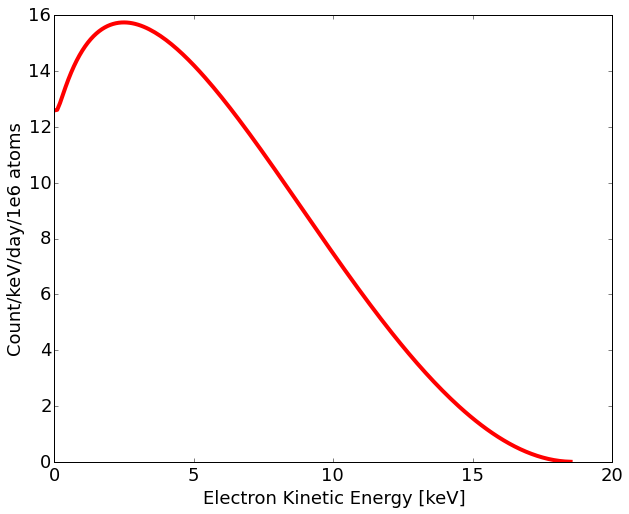

In [4]:
c=1;    # speed of light
C=1e-6; #constant infront of Fermi funciton. Arbitrary. Read Katrin paper if you care about super-allowed and allowed transitions... and nuclear matrix elements that don't matter
me = 511/c**2; # rest mass of our good friend the electron, in keV
Q=18.6 # endpoint of the tritium Beta decay keV. Maximum kinetic energy the electron.
mv=0   # neutrino mass=0. There may exist a 17 keV neutrino, maybe 7 keV!! Will we ever know??? Is it The Dark Matter?? Mystery...
step_T=0.1 #step energy by 0.1 keV
T=arange(0.01, 18.6,step_T) #sweep from 0.01 to the Q value in increments of step_T.
Z=1+1; #Tritium, after the beta decay Z'=1+1;
halflife = 12.32; # half life of the tritium beta decay in years
tau = 365*halflife/0.69; # Decay constant converted to days
n = 1e6; # Assume 1e6 atoms are decaying.
G=(T+me*c**2)/(me*c**2); #Gamma, Total energy(E+M^2) over M^2
B=sqrt((G**2-1)/G**2); # v/c of electron. Ratio of velocity to speed of light in vacuum.
x=(2*pi*Z/137)/B; # note: fine structure constant = 137. 
F_Kat=x*(1/(1-exp(-x))); # Katrin paper... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)
KE=T; #(G-1).*me*c^2; % The kinetic energy, is equal to T
E=KE+me*c**2; # the total energy. KE + rest mass
P=sqrt(E**2-me**2*c**4)/c; # momentum of the electron
N=C*F_Kat*(KE+me)*sqrt((KE+me)**2-me**2)*(Q-KE)**2 # eqution 18 of Katrin paper. Set nutrino mass to zero... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)
s = sum(N[~isnan(N)])*step_T # Total Counts
N = N * (1/s * n/tau) # Decays/keV/day/1e6 atoms

#plot to se beta spectrum for tritium 
figure(0)
plt.plot(T,N,'r',linewidth=4)
plt.xlabel('Electron Kinetic Energy [keV] ',fontsize=18)
plt.ylabel('Count/keV/day/1e6 atoms',fontsize=18)

In [5]:
mat = sio.loadmat('/global/homes/r/rknoche/Sep2015_3DFieldMap_ForPython_v1p0.mat')
x_bins=mat['x_bins'] #in cm
y_bins=mat['y_bins'] #in cm
z_bins=mat['z_bins'] #in mm with cathode at z=0
DriftTimeMap=mat['DriftTimeMap'] #in uSec
FieldMap=mat['FieldMap']/100 #in V/cm 
FieldMap

#Convert dT min/max to Z max/min (in mm) using Lucie's Map
#dTtoZ=0.001082343551729*dT**2  -1.836729127595990*dT + 482.0536 #2015 conversion based on Lucie's map -- From CC:\Program Files\MATLAB\R2012a\bin\LUXCode\Scratch\RichardKnoche\KrypCal_RD\KrypCal_2p21\TritiumMethod\Run04_G1ZDep_Sep2015
#dTtoZ=0.001155011585870*dT**2  -1.855642880280688*dT + 482.6349 #2016 conversion based on Lucie's map -- From CC:\Program Files\MATLAB\R2012a\bin\LUXCode\Scratch\RichardKnoche\KrypCal_RD\KrypCal_2p21\TritiumMethod\Run04_G1ZDep_Feb2016


z_max= 0.001082343551729*myDet.dt_min**2-1.836729127595990*myDet.dt_min+482.0536 #convert zmin in uSec to zmin in mm using Lucie's Map
z_min= 0.001082343551729*myDet.dt_max**2-1.836729127595990*myDet.dt_max+482.0536 #convert zmax in uSec to zmax in mm using Lucie's Map

In [6]:
x_bins=np.squeeze(x_bins)
y_bins=np.squeeze(y_bins)
z_bins=np.squeeze(z_bins)

In [7]:
xyz_to_field=ip.RegularGridInterpolator((x_bins,y_bins,z_bins),FieldMap)
xyz_to_dT=ip.RegularGridInterpolator((x_bins,y_bins,z_bins),DriftTimeMap)

#interp_val=fn((-15,15,400))

In [8]:
#####
trial_m=500; # about 150k with trial_m = 100
trials=sum(ceil(N*trial_m)); #tritium dN/dE is fractional so multiply amplitute. 
subtrials=np.zeros((T.size,1)); #Number of energy bins

S1c=np.zeros((trials,1)); #  Tritium gamma spectrum
S2c=np.zeros((trials,1));     #  Tritium electron spectrum.
dTus=np.zeros((trials,1));
S2x=np.zeros((trials,1));
S2y=np.zeros((trials,1));

kk=0; # kk will equal the total number of simulated tritium events

for jj in range(0, T.size): #% sweep through each energy bin
    print(jj),
    subtrials[jj]=ceil(N[jj]*trial_m) #Number of events for the current energy bin
    energy=T[jj]
    NEST.SetEnergy(energy)    
    
    for ii in range(0, subtrials[jj]-1):
        #Assign XYZ position to the event
        current_x=np.random.uniform(-r_max,r_max,1) #corrected_x
        current_r=np.random.uniform(abs(current_x),r_max,1) #radius
        current_ysign=np.random.randint(0,2,1) #sign of corrected_y
        current_ysign=2*current_ysign-1 #changes from 0 or 1, to -1 or 1
        current_y=current_ysign*sqrt(current_r**2-current_x**2) #corrected_y
        current_z=np.random.uniform(z_min,z_max,1) #corrected_z in mm

        #Get electric field from Lucie's Map, given x,y,z
        current_Efield=xyz_to_field((current_x,current_y,current_z))
        NEST.SetElectricField(current_Efield[0])
    
        #Get drift time from Lucie's map, given x,y,z
        current_dT=xyz_to_dT((current_x,current_y,current_z))
        NEST.SetDriftLocation(current_dT[0])
        
        NEST.DetectorResponse() #throw the dice
        #S1[kk]=NEST.GetS1()
        #S2[kk]=NEST.GetS2()        
        S1c[kk]=NEST.GetS1c()
        S2c[kk]=NEST.GetS2c()
        dTus[kk]=current_z
        S2x[kk]=current_x
        S2y[kk]=current_y
        #Energy[kk]=NEST.GetEnergy()
        kk=kk+1

/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185


In [9]:
#Load the Dec 2013 tritium data.VUV corrected, spike count for S1. XYZ corrected rq with 83Kr. Cut from 35-305us. <20cm radius.
#tritium_data=np.loadtxt('//global/homes/r/rknoche/Run04_Sep2014_Kr2p14_CH3TData_TwoLineFloat.txt')
tritium_data=np.loadtxt('//global/homes/r/rknoche/Run04_Sep2015_Kr2p22_CH3TData_ZCorrOnly.txt')
s1_data=tritium_data[:,0]


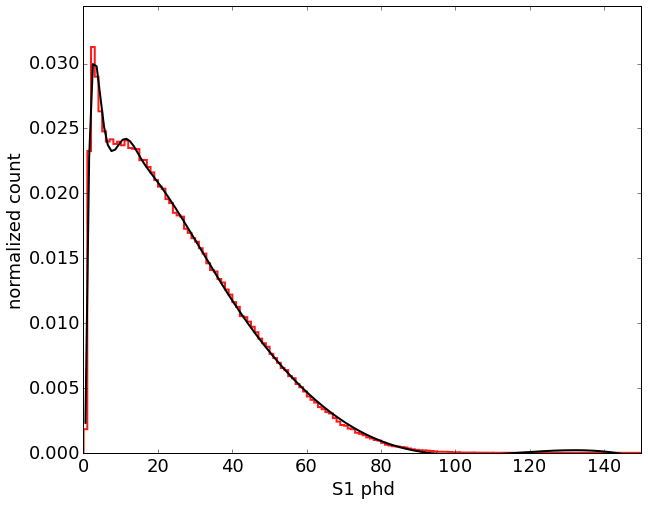

In [10]:
s1_NEST = S1c;

binwidth=1 # phd
n_NEST_S1, bin_edges_NEST_S1, patches = plt.hist(s1_NEST, bins=np.arange(0.05, 150 + binwidth, binwidth), normed=1, facecolor='none',edgecolor='red',linewidth=2, histtype='step', alpha=0.9)
plt.xlabel('S1 phd',fontsize=18)
plt.ylabel('normalized count',fontsize=18)
plt.xlim([0,100])
left,right = bin_edges_NEST_S1[:-1],bin_edges_NEST_S1[1:]
bin_center_NEST_S1=(right+left)/2

s = ip.UnivariateSpline(bin_center_NEST_S1,n_NEST_S1)
s.set_smoothing_factor(1e-5)
plt.plot(bin_center_NEST_S1,s(bin_center_NEST_S1),'k',linewidth=2)

plt.xlim([0,150]);
plt.ylim([0, 1.1*max(n_NEST_S1)]);

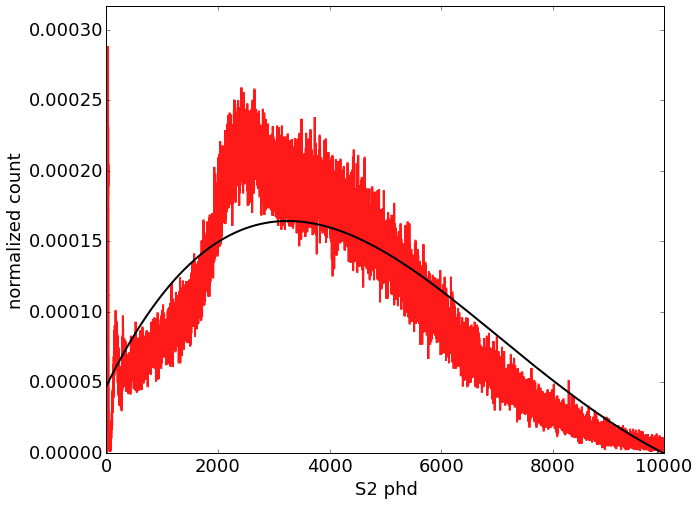

In [11]:
s2_NEST = S2c;

binwidth=1 # phd
n_NEST_S2, bin_edges_NEST_S2, patches = plt.hist(s2_NEST, bins=np.arange(0.05, 15000 + binwidth, binwidth), normed=1, facecolor='none',edgecolor='red',linewidth=2, histtype='step', alpha=0.9)
plt.xlabel('S2 phd',fontsize=18)
plt.ylabel('normalized count',fontsize=18)
plt.xlim([0,10000])
left,right = bin_edges_NEST_S2[:-1],bin_edges_NEST_S2[1:]
bin_center_NEST_S2=(right+left)/2

s = ip.UnivariateSpline(bin_center_NEST_S2,n_NEST_S2)
s.set_smoothing_factor(1e-5)
plt.plot(bin_center_NEST_S2,s(bin_center_NEST_S2),'k',linewidth=2)

plt.xlim([0,10000]);
plt.ylim([0, 1.1*max(n_NEST_S2)]);

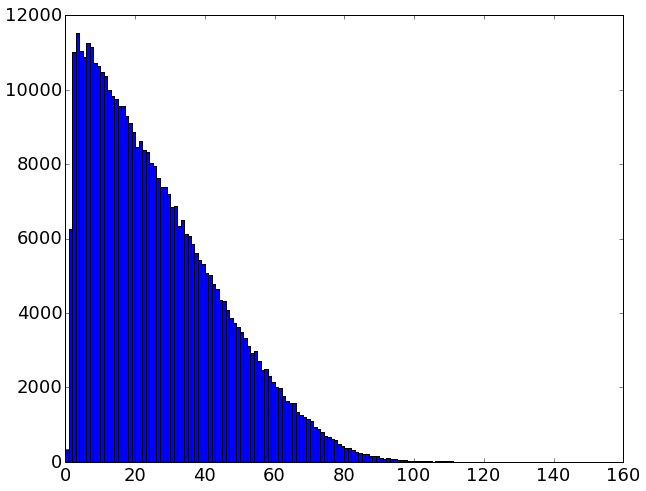

In [12]:
binwidth=1
num_data, num_data_bins, num_data_patches=plt.hist(s1_data,bins=np.arange(0.05, 150 + binwidth, binwidth));

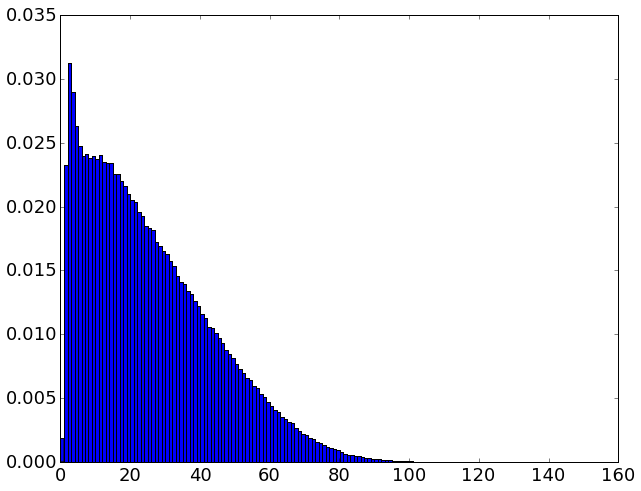

In [32]:
S2radius=(S2x**2 + S2y**2)**(1/2)
num_sim, num_sim_bins, num_sim_patches= plt.hist(s1_NEST, bins=np.arange(0.05, 150 + binwidth, binwidth),normed=1);

(0, 150)

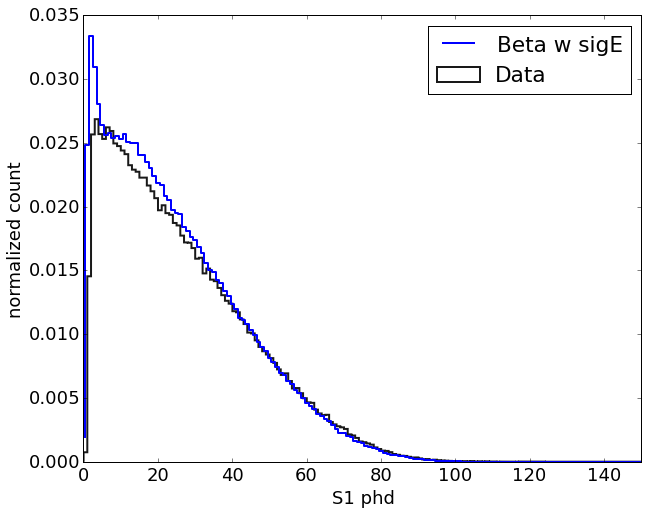

In [14]:
binwidth=1 #phd

n_data, bin_edges_data, patches = plt.hist(s1_data, bins=np.arange(0.05, 150 + binwidth, binwidth), normed=1, facecolor='none',edgecolor='black',linewidth=2, histtype='step', alpha=0.9)
plt.xlabel('S1 phd',fontsize=18)
plt.ylabel('normalized count',fontsize=18)

left,right = bin_edges_data[:-1],bin_edges_data[1:]
bin_center_data=(right+left)/2

data_scale_factor=sum(n_data[bin_center_data>40])/sum(n_NEST_S1[bin_center_NEST_S1>40])

plt.step(bin_center_NEST_S1,n_NEST_S1*data_scale_factor,'b',linewidth=2)

plt.legend(('Beta w sigE','Data'))
plt.xlim([0,150])


In [15]:
SimToData_scale_factor=sum(num_data[bin_center_data>40])/sum(num_sim[bin_center_NEST_S1>40])
frac_res=(num_data-num_sim*SimToData_scale_factor)/sqrt(num_data)

In [16]:
thresh=num_data/(num_sim*SimToData_scale_factor)
thresh_err=sqrt( (sqrt(num_data)/(num_sim*SimToData_scale_factor))**2 + (num_data/(num_sim*(SimToData_scale_factor**2)))**2)
no_nan_cut=np.logical_not(numpy.isnan(thresh))*np.logical_not(numpy.isinf(thresh))
thresh_nonan=thresh[no_nan_cut]
xbin_nonan=bin_center_NEST_S1[no_nan_cut]

In [17]:
def func(x,mu,sig):
    return (1/2)*scipy.special.erf((x-mu)/(sqrt(2)*sig))+(1/2)


In [18]:
popt, pcov = scipy.optimize.curve_fit(func,xbin_nonan,thresh_nonan)
thresh_yval=(1/2)*scipy.special.erf((bin_center_NEST_S1-popt[0])/(sqrt(2)*popt[1]))+(1/2)

popt

array([ 1.11003512,  2.16137779])

In [19]:
from scipy import optimize

def line( x, p):
    return p[0]*x + p[1] 

def linef( x, p0, p1):
    return p0*x + p1

def erfit( x, p0, p1):
    return (1/2)*scipy.special.erf((x-p0)/(sqrt(2)*p1))+(1/2)
    


def fit_function(p0, datax, datay, function, **kwargs):

    errfunc = lambda p, x, y: function(x,p) - y

    ##################################################
    ## 1. COMPUTE THE FIT AND FIT ERRORS USING leastsq
    ##################################################

    # If using optimize.leastsq, the covariance returned is the 
    # reduced covariance or fractional covariance, as explained
    # here :
    # http://stackoverflow.com/questions/14854339/in-scipy-how-and-why-does-curve-fit-calculate-the-covariance-of-the-parameter-es
    # One can multiply it by the reduced chi squared, s_sq, as 
    # it is done in the more recenly implemented scipy.curve_fit
    # The errors in the parameters are then the square root of the 
    # diagonal elements.   

    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq( errfunc, p0, args=(datax, datay), \
                          full_output=1)

    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append( numpy.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = numpy.array(error) 

    ###################################################
    ## 2. COMPUTE THE FIT AND FIT ERRORS USING curvefit
    ###################################################

    # When you have an error associated with each dataY point you can use 
    # scipy.curve_fit to give relative weights in the least-squares problem. 
    datayerrors = kwargs.get('datayerrors', None)
    curve_fit_function = kwargs.get('curve_fit_function', function)
    if datayerrors is None:
        pfit, pcov = \
            optimize.curve_fit(curve_fit_function,datax,datay,p0=p0)
    else:
        pfit, pcov = \
             optimize.curve_fit(curve_fit_function,datax,datay,p0=p0,\
                                sigma=datayerrors)
    error = [] 
    for i in range(len(pfit)):
        try:
          error.append( numpy.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = numpy.array(error)  


    ####################################################
    ## 3. COMPUTE THE FIT AND FIT ERRORS USING bootstrap
    ####################################################        

    # An issue arises with scipy.curve_fit when errors in the y data points
    # are given.  Only the relative errors are used as weights, so the fit
    # parameter errors, determined from the covariance do not depended on the
    # magnitude of the errors in the individual data points.  This is clearly wrong. 
    # 
    # To circumvent this problem I have implemented a simple bootstraping 
    # routine that uses some Monte-Carlo to determine the errors in the fit
    # parameters.  This routines generates random datay points starting from
    # the given datay plus a random variation. 
    #
    # The random variation is determined from average standard deviation of y
    # points in the case where no errors in the y data points are avaiable.
    #
    # If errors in the y data points are available, then the random variation 
    # in each point is determined from its given error. 
    # 
    # A large number of random data sets are produced, each one of the is fitted
    # an in the end the variance of the large number of fit results is used as 
    # the error for the fit parameters. 

    # Estimate the confidence interval of the fitted parameter using
    # the bootstrap Monte-Carlo method
    # http://phe.rockefeller.edu/LogletLab/whitepaper/node17.html
    residuals = errfunc( pfit, datax, datay)
    s_res = numpy.std(residuals)
    ps = []
    # 100 random data sets are generated and fitted
    for i in range(100):
      if datayerrors is None:
          randomDelta = numpy.random.normal(0., s_res, len(datay))
          randomdataY = datay + randomDelta
      else:
          randomDelta =  numpy.array( [ \
                             numpy.random.normal(0., derr,1)[0] \
                             for derr in datayerrors ] ) 
          randomdataY = datay + randomDelta
      randomfit, randomcov = \
          optimize.leastsq( errfunc, p0, args=(datax, randomdataY),\
                            full_output=0)
      ps.append( randomfit ) 

    ps = numpy.array(ps)
    mean_pfit = numpy.mean(ps,0)
    Nsigma = 1. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * numpy.std(ps,0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit


    # Print results 
    print "\nlestsq method :"
    print "pfit = ", pfit_leastsq
    print "perr = ", perr_leastsq
    print "\ncurvefit method :"
    print "pfit = ", pfit_curvefit
    print "perr = ", perr_curvefit
    print "\nbootstrap method :"
    print "pfit = ", pfit_bootstrap
    print "perr = ", perr_bootstrap

In [20]:
pcov

array([[  46.23479525,  -38.76904059],
       [ -38.76904059,  132.13987955]])

In [21]:
popt_err=np.sqrt(np.diag(pcov))
popt_err

array([  6.79961729,  11.49521116])

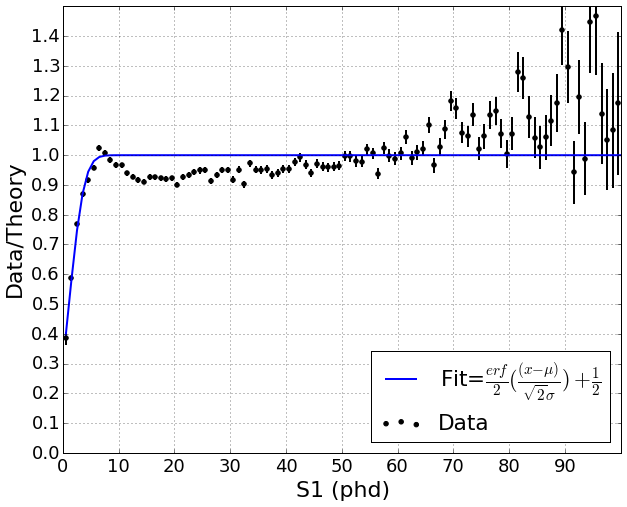

In [38]:
thresh=num_data/(num_sim*SimToData_scale_factor)
thresh_err=sqrt( (sqrt(num_data)/(num_sim*SimToData_scale_factor))**2 + (num_data/(num_sim*(SimToData_scale_factor**2)))**2)
plt.errorbar(bin_center_NEST_S1,thresh,yerr=thresh_err,xerr=None,ecolor='black',elinewidth=2,capsize=0,fmt=None)
plt.xlim([0,100])
plt.ylim([0,1.5])
plt.scatter(bin_center_NEST_S1,thresh,c='black',marker='o')
plt.plot(bin_center_NEST_S1,thresh_yval,linewidth=2)
plt.xticks(np.arange(0,100,10))
plt.yticks(np.arange(0,1.5,0.1))
plt.ylabel('Data/Theory',fontsize=22)
plt.xlabel('S1 (phd)',fontsize=22)
plt.legend((r'Fit=$\frac{erf}{2}(\frac{(x-\mu)}{\sqrt{2}\sigma}) + \frac{1}{2}$','Data'),loc='lower right')


ax=plt.gca()
ax.grid(True)